# classification es el notebook oficial de clasificación

### - Limpiamos los datos según conclusiones del notebook main
### - Probaremos distintos algorítmos de clasificación y compararemos los resultados
### - Utilizamos el dataset de train ya recortado por la cátedra

---





## ACA TODOS LOS IMPORTS DEL NOTEBOOK

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, validation_curve
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc, roc_curve


## LECTURA Y LIMPIEZA DEL DATASET

In [2]:
df_orig = pd.read_csv(r"DS_G3_HeartFailure_FULL_train.csv",index_col=0)

## Transformaciones necesarias al df

In [3]:
df_cleaned = df_orig.drop(["time","anaemia","diabetes","high_blood_pressure","sex","smoking"],axis=1)
#df_cleaned = df_orig.drop(["anaemia","diabetes","high_blood_pressure","sex","smoking"],axis=1)
# NOS QUEDAMOS CON AGE, EJECTION_FRACTION, SERUM_CREATININE, SERUM_SODIUM Y DEATH_EVENT
df_cleaned.head()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,DEATH_EVENT
55,95.0,371,30,461000.0,2.0,132,1
180,40.0,478,30,303000.0,0.9,136,0
237,70.0,232,30,173000.0,1.2,132,0
280,70.0,2695,40,241000.0,1.0,137,0
181,59.0,176,25,221000.0,1.0,136,1


In [4]:
feat_train, targ_train = df_cleaned.drop(["DEATH_EVENT"],axis=1),df_cleaned["DEATH_EVENT"]

In [5]:
scaler = StandardScaler()
feat_train = scaler.fit_transform(feat_train)
#APLICAMOS SMOTE PARA AUMENTAR LA CANTIDAD DE SAMPLES Y BALANCEAR EL TARGET
feat_train, targ_train = SMOTE(random_state=420).fit_resample(feat_train, targ_train)
feat_train.shape

(326, 6)

## ACA TENEMOS EL DATASET RECORTADO Y STANDARIZADO 

In [6]:
score_metric = "recall" # Queremos pocos FN, es decir pacientes q decimos q NO tienen riesgo pero SI.

---

## ALGUNAS FUNCIONES UTILES PARA GRAFICAR

In [111]:
def aoc_curves (model,feat,targ):
    try:
        predicted_p = cross_val_predict(model,feat,targ,cv=10,method="predict_proba")
    except:
        return
    fpr, tpr, thres = roc_curve(targ, predicted_p[:,1])
    precisions, recalls, thres = precision_recall_curve(targ, predicted_p[:,1])
    roc_auc = auc(fpr, tpr)
    pr_auc = auc(recalls, precisions)

    fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(20,8))
    ax1.plot(fpr,tpr,label = "{}:{:.3f}".format(str(model)[:3],roc_auc))
    ax1.plot([0,1],[0,1],'--k', alpha=0.5)
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Curva ROC')
    ax1.legend()
    ax2.plot(recalls,precisions,label = "PR AOC:{:.3f}".format(pr_auc))
    ax2.plot([1,0],[0,1],'--k', alpha=0.5)
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precisión')
    ax2.set_title('Curva PR')
    ax2.legend()

In [8]:
def model_setup (model):
    model.fit(feat_train,targ_train)
    scoring = cross_val_score(model, feat_train, targ_train,cv=10, scoring=score_metric)
    print("Cross Validation Score: {:.3f} +/- {:.3f}".format(scoring.mean(),scoring.std()))
    predicted = cross_val_predict(model,feat_train,targ_train,cv=10)
    print(classification_report(targ_train, predicted))
    cm = confusion_matrix(targ_train, predicted)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

In [114]:
modelos = [
    Perceptron(fit_intercept=False, max_iter=40000),
    Perceptron(fit_intercept=False, max_iter=40000,penalty="l2",random_state=420,alpha=1e-5,eta0=0.05),
    LogisticRegression(fit_intercept=False, dual=False, max_iter=40000,C=2),
    SVC(probability=True,gamma=0.61,C=0.85),
    RandomForestClassifier(n_estimators=400,min_impurity_decrease=2e-4),
    AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),learning_rate=0.2),
    VotingClassifier(estimators=[('lr', LogisticRegression(fit_intercept=False, dual=False, max_iter=40000,C=2)), ('tree', RandomForestClassifier(n_estimators=400,min_impurity_decrease=2e-4)), ('svc', SVC(probability=True,gamma=0.61,C=0.85))],voting='hard'),
    VotingClassifier(estimators=[('lr', LogisticRegression(fit_intercept=False, dual=False, max_iter=40000,C=2)), ('tree', RandomForestClassifier(n_estimators=400,min_impurity_decrease=2e-4)), ('svc', SVC(probability=True,gamma=0.61,C=0.85))],voting='soft')
]
scores = []
for model in modelos:
    model.fit(feat_train,targ_train)
    scores.append(cross_val_score(model, feat_train, targ_train,cv=15, scoring=score_metric))


In [140]:
scores = pd.DataFrame(np.array(scores).T)
scores.columns = ["Per (BL)","Per_op","LR_op","SVC_op","RF_op","ADA_op","VotHard","VotSoft"]

In [138]:
meaned_scores = [0.657,0.711,0.801,0.877,0.865,0.781,0.871,0.862]

<BarContainer object of 8 artists>

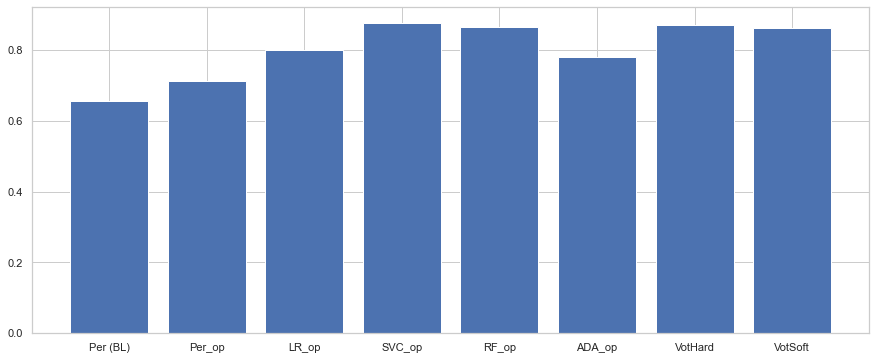

In [144]:
plt.figure(figsize=(15,6))
plt.bar(scores.columns,meaned_scores)

In [120]:
scores

,Per (BL),Per_op,LR_op,SVC_op,RF_op,ADA_op,VotHard,VotSoft
0,0.545455,0.545455,0.636364,0.818182,0.727273,0.636364,0.818182,0.818182
1,0.545455,0.363636,0.727273,0.909091,0.727273,0.909091,0.818182,0.818182
2,0.636364,0.363636,0.727273,0.818182,0.909091,0.636364,0.818182,0.818182
3,0.545455,0.454545,0.909091,0.909091,0.727273,0.727273,0.818182,0.818182
4,0.727273,0.727273,0.818182,0.818182,0.818182,0.727273,0.818182,0.818182
5,0.727273,0.727273,0.818182,0.818182,0.818182,0.727273,0.818182,0.818182
6,0.636364,0.727273,0.818182,0.818182,0.727273,0.727273,0.818182,0.818182
7,0.727273,0.818182,0.909091,0.909091,1.000000,0.909091,1.000000,1.000000
8,0.818182,0.727273,0.818182,0.818182,1.000000,1.000000,0.909091,0.909091
9,0.636364,0.727273,0.818182,1.000000,0.909091,0.818182,1.000000,1.000000


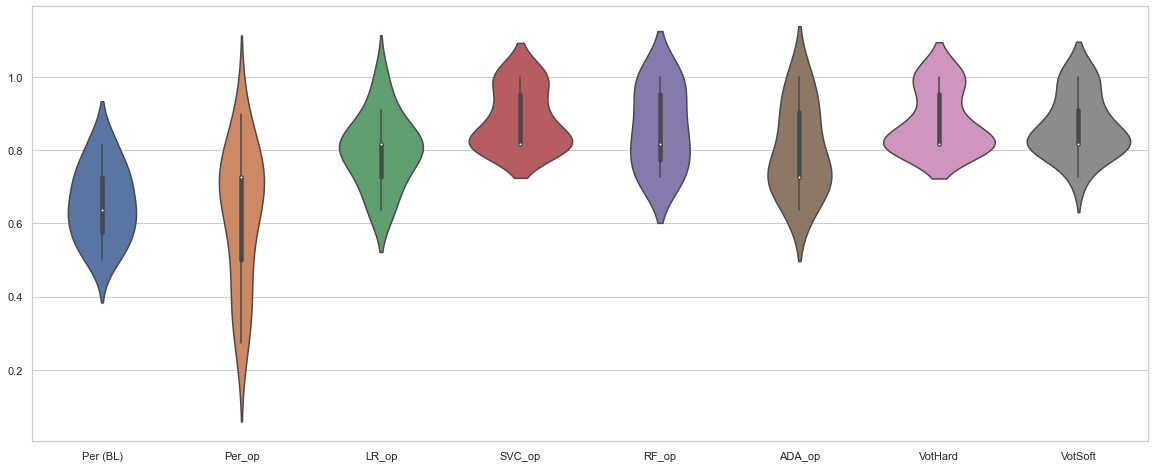

In [121]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(20,8))
sns.violinplot(data=scores)
plt.show()

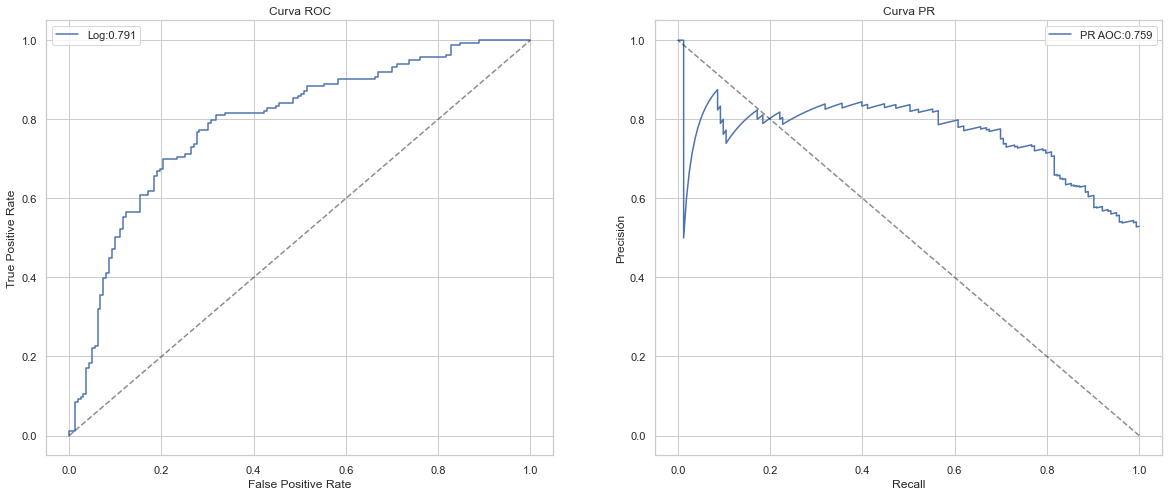

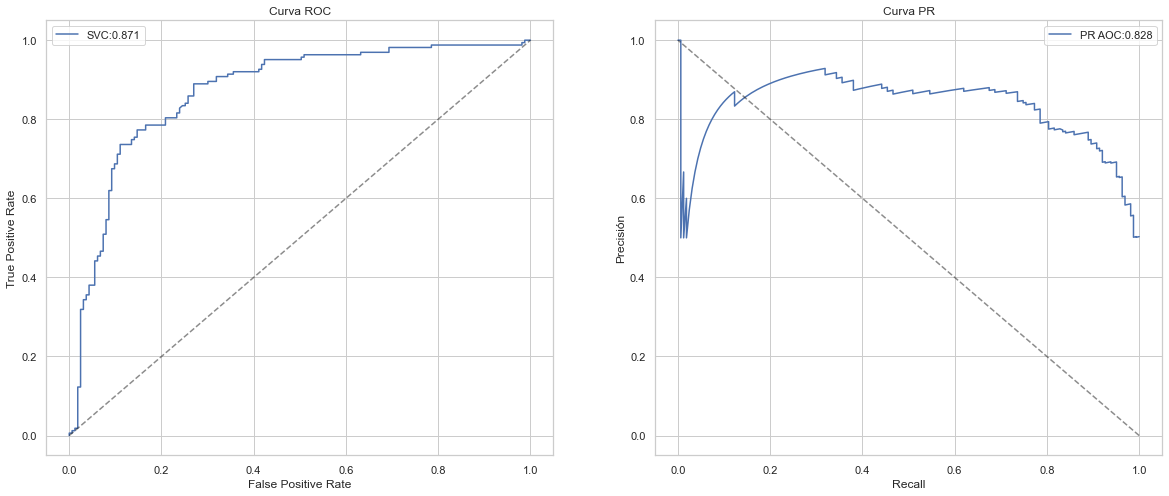

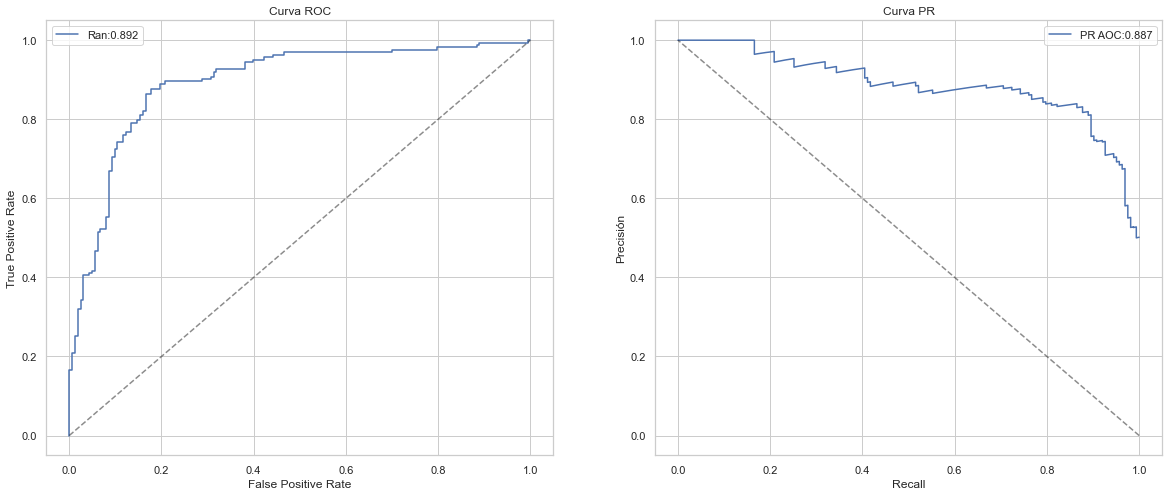

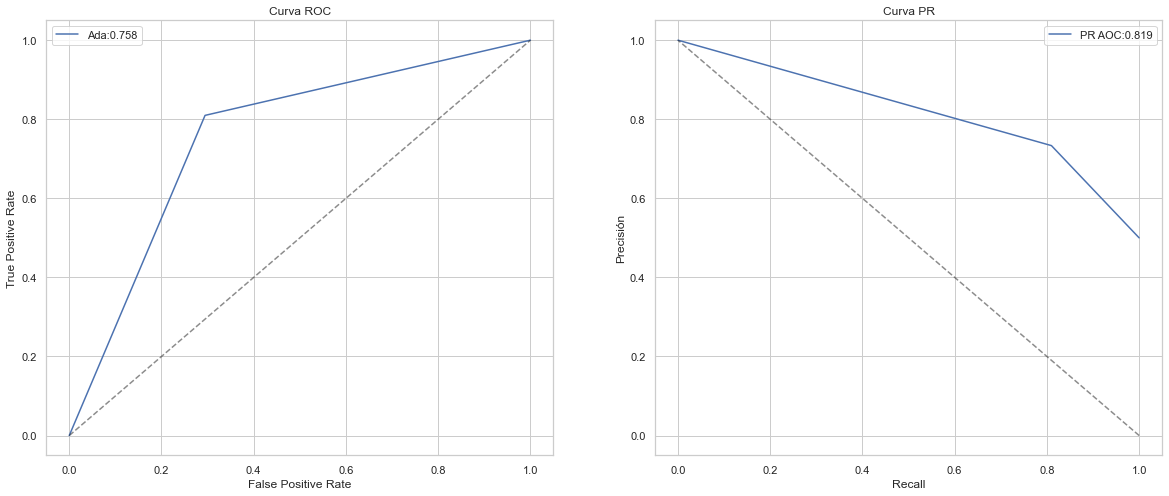

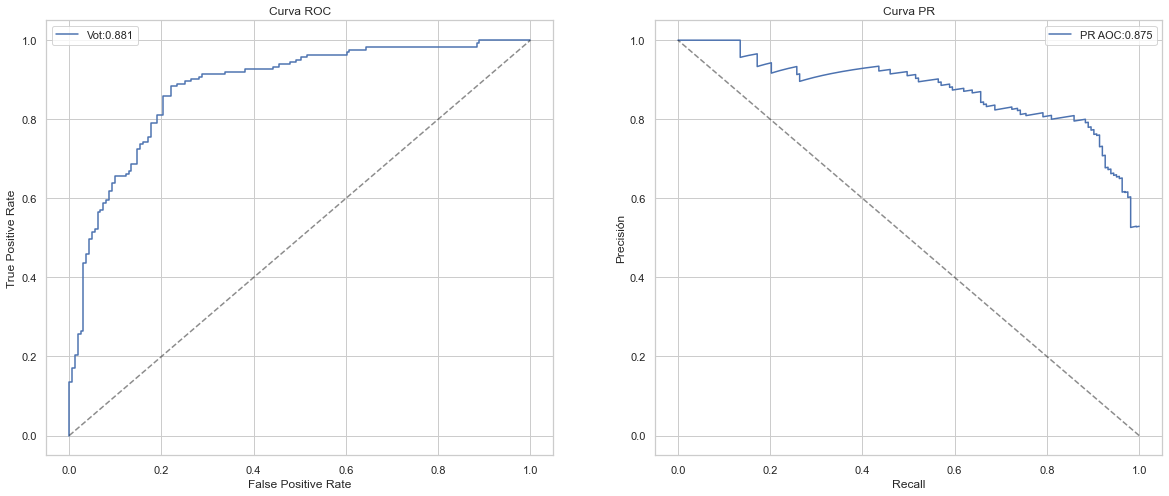

In [112]:
for model in modelos:
    aoc_curves(model,feat_train,targ_train)

---
---
---

# ADA BOOSTING

### Cambia levemente la metodologia, usa early stopping

In [273]:
feat_train_2, feat_val, targ_train_2, targ_val = train_test_split(feat_train,targ_train,random_state=420)
# NECESARIO CREAR DATOS DE VALIDACION PARA USAR XGBC

In [274]:
xgbc_model = XGBClassifier(use_label_encoder=False,objective='binary:hinge',learning_rate=0.05,n_estimators=500)
xgbc_model.fit(feat_train_2,targ_train_2,eval_set=[(feat_train_2, targ_train_2), (feat_val, targ_val)],eval_metric="error",early_stopping_rounds=20,verbose=True)
xgbc_scoring = cross_val_score(xgbc_model, feat_train, targ_train,cv=10, scoring=score_metric)
print("Cross Validation Score: {:.3f} +/- {:.3f}".format(xgbc_scoring.mean(),xgbc_scoring.std())) 

[0]	validation_0-error:0.52459	validation_1-error:0.42683
[1]	validation_0-error:0.52459	validation_1-error:0.42683
[2]	validation_0-error:0.52459	validation_1-error:0.42683
[3]	validation_0-error:0.52459	validation_1-error:0.42683
[4]	validation_0-error:0.52459	validation_1-error:0.42683
[5]	validation_0-error:0.52459	validation_1-error:0.42683
[6]	validation_0-error:0.52459	validation_1-error:0.42683
[7]	validation_0-error:0.52459	validation_1-error:0.42683
[8]	validation_0-error:0.52459	validation_1-error:0.42683
[9]	validation_0-error:0.52459	validation_1-error:0.42683
[10]	validation_0-error:0.52459	validation_1-error:0.42683
[11]	validation_0-error:0.18443	validation_1-error:0.29268
[12]	validation_0-error:0.15574	validation_1-error:0.29268
[13]	validation_0-error:0.11885	validation_1-error:0.26829
[14]	validation_0-error:0.10656	validation_1-error:0.28049
[15]	validation_0-error:0.10656	validation_1-error:0.26829
[16]	validation_0-error:0.10246	validation_1-error:0.26829
[17]	va

# RED NEURONAL SIMPLE

In [293]:
keras.backend.clear_session()

In [294]:
input = keras.layers.Input(shape=[6,])
flatten = keras.layers.Flatten()(input)
hidden1 = keras.layers.Dense(100, activation="relu")(flatten)
dropout = keras.layers.Dropout(rate=0.2)(hidden1)
hidden2 = keras.layers.Dense(100, activation="relu")(hidden1)
output = keras.layers.Dense(1, activation="sigmoid")(hidden2)

model = keras.models.Model(inputs=[input], outputs=[output])

In [295]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              metrics=[tf.keras.metrics.Recall()])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6)]               0         
_________________________________________________________________
flatten (Flatten)            (None, 6)                 0         
_________________________________________________________________
dense (Dense)                (None, 100)               700       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 10,901
Trainable params: 10,901
Non-trainable params: 0
_________________________________________________________________


In [296]:
history = model.fit(feat_train, targ_train, epochs=2000, batch_size=32,
                    validation_split=0.2,
                    callbacks=[keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True)])

Epoch 1/2000
9/9 [==============================] - 0s 16ms/step - loss: 0.6872 - recall: 0.6701 - val_loss: 0.6978 - val_recall: 0.4545
Epoch 2/2000
9/9 [==============================] - 0s 2ms/step - loss: 0.6260 - recall: 0.4227 - val_loss: 0.7402 - val_recall: 0.3788
Epoch 3/2000
9/9 [==============================] - 0s 2ms/step - loss: 0.5887 - recall: 0.4639 - val_loss: 0.7525 - val_recall: 0.3788
Epoch 4/2000
9/9 [==============================] - 0s 3ms/step - loss: 0.5598 - recall: 0.5361 - val_loss: 0.7265 - val_recall: 0.5000
Epoch 5/2000
9/9 [==============================] - 0s 3ms/step - loss: 0.5340 - recall: 0.5773 - val_loss: 0.7359 - val_recall: 0.5152
Epoch 6/2000
9/9 [==============================] - 0s 2ms/step - loss: 0.5204 - recall: 0.5979 - val_loss: 0.7278 - val_recall: 0.5758
Epoch 7/2000
9/9 [==============================] - 0s 2ms/step - loss: 0.5072 - recall: 0.6289 - val_loss: 0.7237 - val_recall: 0.6212
Epoch 8/2000
9/9 [=============================

In [297]:
model.evaluate(feat_train,targ_train)

11/11 [==============================] - 0s 500us/step - loss: 0.0677 - recall: 0.9877


[0.0676703229546547, 0.987730085849762]

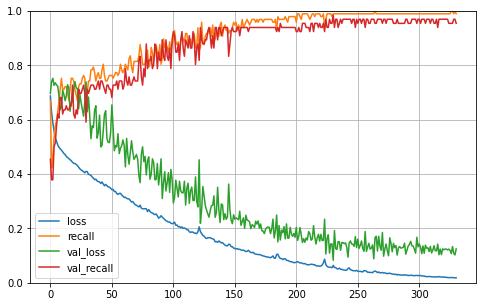

In [298]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

(array([126.,  24.,   7.,   3.,   4.,   2.,   1.,   5.,  13., 141.]),
 array([1.5837648e-07, 1.0000014e-01, 2.0000012e-01, 3.0000010e-01,
        4.0000010e-01, 5.0000006e-01, 6.0000008e-01, 7.0000005e-01,
        8.0000001e-01, 9.0000004e-01, 1.0000000e+00], dtype=float32),
 <BarContainer object of 10 artists>)

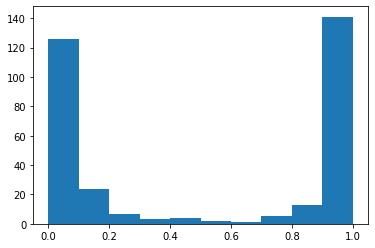

In [300]:
plt.hist(model.predict(feat_train))

(array([163.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 163.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

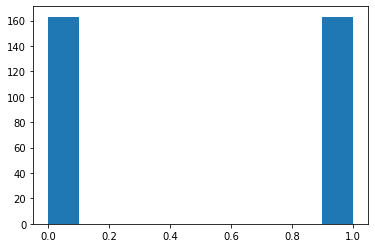

In [301]:
plt.hist(targ_train)

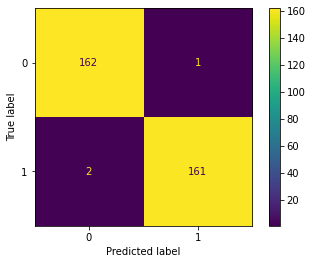

In [302]:
cm = confusion_matrix(targ_train, model.predict(feat_train)>0.5)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()